In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc, cohen_kappa_score
from sklearn.linear_model import LogisticRegression

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha = ha.dropna()
#ha.head()

In [ ]:
#ha.dtypes

## Part One: Fitting Models
## kNN

In [3]:
X = ha.drop('output', axis=1)
y = ha['output']

ct = ColumnTransformer([
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"]),
    ("dummify", OneHotEncoder(drop='first', sparse_output=False), ["cp", "restecg"])
], remainder="passthrough").set_output(transform = "pandas")

knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier())
])

#ct.fit_transform(ha).columns

In [4]:
param_grid = {'knn__n_neighbors': range(1, 31)}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('dummify',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['cp',
                                                                          'restecg'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 31)}, scoring='roc_auc')

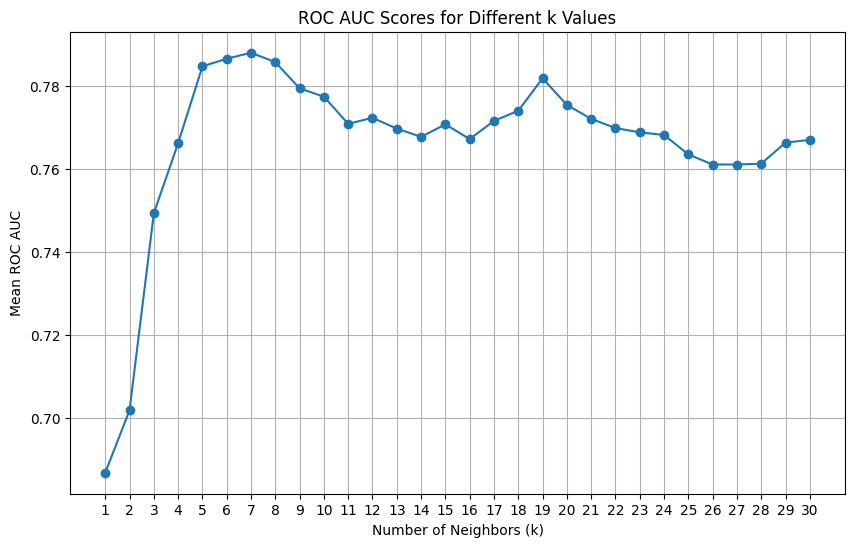

In [5]:
import matplotlib.pyplot as plt
results = grid_search.cv_results_

# Get all k values and corresponding mean ROC AUC scores
k_values = results['param_knn__n_neighbors']
mean_roc_auc = results['mean_test_score']

# Plot ROC AUC scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_roc_auc, marker='o')
plt.title("ROC AUC Scores for Different k Values")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean ROC AUC")
plt.xticks(k_values)
plt.grid()
plt.show()

In [6]:
best_knn = Pipeline([
    ('preprocess', ct),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])

best_knn.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach']),
                                                 ('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['cp', 'restecg'])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

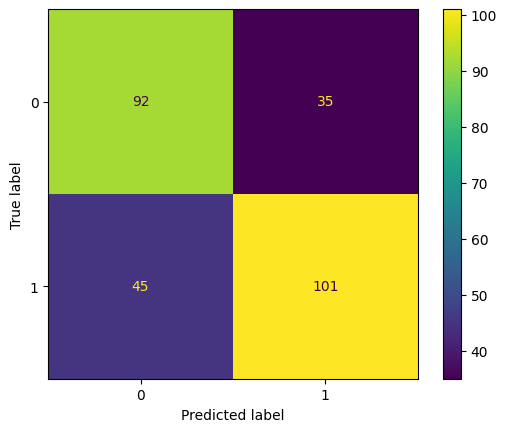

In [7]:
# confusion matrix
y_pred_cv = cross_val_predict(best_knn, X, y, cv=5)

conf_matrix = confusion_matrix(y, y_pred_cv)
#conf_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn.classes_)
disp.plot(cmap="viridis")

In [8]:
print(classification_report(y, y_pred_cv))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       127
           1       0.74      0.69      0.72       146

    accuracy                           0.71       273
   macro avg       0.71      0.71      0.71       273
weighted avg       0.71      0.71      0.71       273



In [9]:
# True Positive Rate(Recall)
kNN_recall = 101/(101+45)
# Precision (Positive Predicted Value)
kNN_precision = 101/(101+35)
# True Negative Rate (Specificity)
kNN_speci = 92/(92+35)

knn_df = pd.DataFrame({
    'Metric': ['True Positive Rate', 'Precision', 'True Negative Rate'],
    'kNN': [kNN_recall, kNN_precision, kNN_speci]
})

print(knn_df)

               Metric       kNN
0  True Positive Rate  0.691781
1           Precision  0.742647
2  True Negative Rate  0.724409


In [10]:
knn_accuracy = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validated Accuracy: {knn_accuracy.mean():.2f}")

Cross-Validated Accuracy: 0.71


## Logistic Regression

In [11]:
logreg_pipeline = Pipeline([
    ('preprocess', ct),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

In [12]:
# Define the parameter grid
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],       # Type of penalty (l1 for lasso, l2 for ridge)
    'logreg__solver': ['liblinear', 'saga']  # Solver (adjust for penalty type)
}


In [13]:
# Perform GridSearchCV
grid_search_logreg = GridSearchCV(logreg_pipeline, logreg_param_grid, scoring='roc_auc', cv=5)

# Fit the grid search
grid_search_logreg.fit(X, y)
best_params = grid_search_logreg.best_params_
best_roc_auc = grid_search_logreg.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated ROC AUC: {best_roc_auc}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validated ROC AUC: 0.8651458885941645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
best_params = {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

best_logreg = Pipeline([
    ('preprocess', ct),
    ('logreg', LogisticRegression(C=best_params['logreg__C'],
                                  penalty=best_params['logreg__penalty'],
                                  solver=best_params['logreg__solver'],
                                  max_iter=1000, random_state=42))
])
best_logreg.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach']),
                                                 ('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['cp', 'restecg'])])),
                ('logreg',
                 LogisticRegression(C=1, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

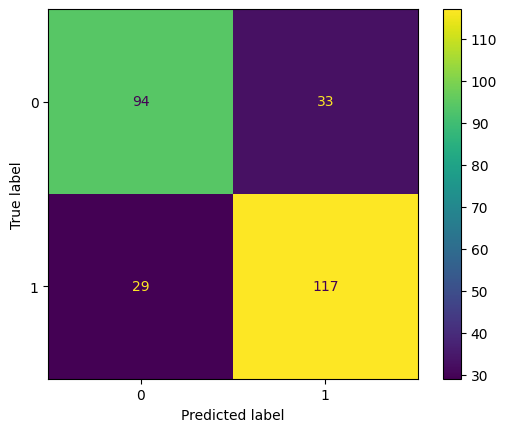

In [15]:
# confusion matrix
y_pred_cv = cross_val_predict(best_logreg, X, y, cv=5)

conf_matrix = confusion_matrix(y, y_pred_cv)
#conf_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_logreg.named_steps['logreg'].classes_)
disp.plot(cmap="viridis")

In [16]:
print(classification_report(y, y_pred_cv))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       127
           1       0.78      0.80      0.79       146

    accuracy                           0.77       273
   macro avg       0.77      0.77      0.77       273
weighted avg       0.77      0.77      0.77       273



In [17]:
# True Positive Rate(Recall)
logreg_recall = 117/(117+29)
# Precision (Positive Predicted Value)
logreg_precision = 117/(117+33)
# True Negative Rate (Specificity)
logreg_speci = 94/(94+33)

logreg_df = pd.DataFrame({
    'Metric': ['True Positive Rate', 'Precision', 'True Negative Rate'],
    'Logistic Regression': [logreg_recall, logreg_precision, logreg_speci]
})

print(logreg_df)

               Metric  Logistic Regression
0  True Positive Rate             0.801370
1           Precision             0.780000
2  True Negative Rate             0.740157


In [18]:
logreg = best_logreg.named_steps['logreg']
feature_names = ct.get_feature_names_out()

# Extract coefficients and associate them with feature names
coefficients = logreg.coef_[0]  # Coefficients for the first class
importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance = importance.sort_values('Coefficient', ascending=False)

print(importance)

                Feature  Coefficient
4         dummify__cp_1     1.646944
5         dummify__cp_2     1.626435
6         dummify__cp_3     1.253831
3  standardize__thalach     0.771272
7    dummify__restecg_1     0.354413
0      standardize__age    -0.206870
8    dummify__restecg_2    -0.229062
2     standardize__chol    -0.255847
1   standardize__trtbps    -0.292355
9        remainder__sex    -1.771709


From the coefficients list, 'sex' is the most important predictor

In [19]:
logreg_accuracy = cross_val_score(best_logreg, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validated Accuracy: {logreg_accuracy.mean():.2f}")

Cross-Validated Accuracy: 0.77


## Decision Tree

In [21]:
dt_pipeline = Pipeline([
    ('preprocess', ct),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [22]:
param_grid = {
    'dt__max_depth': range(1, 21),
    'dt__min_samples_leaf': range(1, 15)
}

grid_search_dt = GridSearchCV(dt_pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search_dt.fit(X, y)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardize',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'trtbps',
                                                                          'chol',
                                                                          'thalach']),
                                                                        ('dummify',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['cp',
                                                                          'restecg'])])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__max_depth': range(1, 21),
                         'dt__min_samples_leaf': range(1, 15)},
             scoring='roc_auc')

In [23]:
print(grid_search_dt.best_params_)
print(grid_search_dt.best_score_)

{'dt__max_depth': 5, 'dt__min_samples_leaf': 14}
0.7758684350132625


In [24]:
best_dt = Pipeline([
    ('preprocess', ct),
    ('dt', DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 14, random_state=42))
])

best_dt.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalach']),
                                                 ('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['cp', 'restecg'])])),
                ('dt',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=14,
                                        random_state=42))])

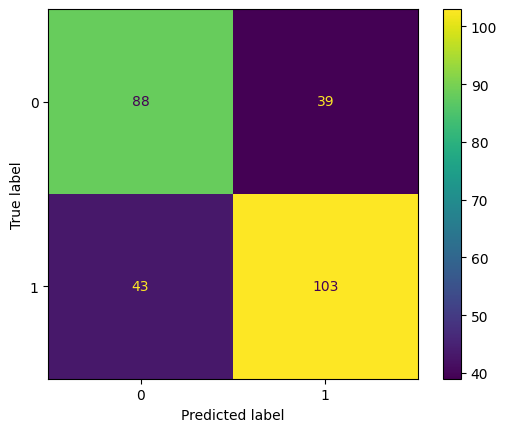

In [25]:
# confusion matrix
y_pred_cv = cross_val_predict(best_dt, X, y, cv=5)

conf_matrix = confusion_matrix(y, y_pred_cv)
#conf_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_dt.named_steps['dt'].classes_)
disp.plot(cmap="viridis")

In [26]:
print(classification_report(y, y_pred_cv))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       127
           1       0.73      0.71      0.72       146

    accuracy                           0.70       273
   macro avg       0.70      0.70      0.70       273
weighted avg       0.70      0.70      0.70       273



In [27]:
# True Positive Rate(Recall)
dt_recall = 103/(103+43)
# Precision (Positive Predicted Value)
dt_precision = 103/(103+39)
# True Negative Rate (Specificity)
dt_speci = 88/(88+39)

dt_df = pd.DataFrame({
    'Metric': ['True Positive Rate', 'Precision', 'True Negative Rate'],
    'Decision tree': [dt_recall, dt_precision, dt_speci]
})

print(dt_df)

               Metric  Decision tree
0  True Positive Rate       0.705479
1           Precision       0.725352
2  True Negative Rate       0.692913


In [28]:
dt_accuracy = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validated Accuracy: {dt_accuracy.mean():.2f}")

Cross-Validated Accuracy: 0.70


## Interpretation
Calculate the absolute values of feature importances and normalize them to compare across the models, since the importances methods used are different in the three models. Logistic regression uses coefficients, while kNN and decision tree models are non-parametric methods.

In [29]:
# use permutation_importance to find the importance of the predictors in kNN model and then standardize the values
from sklearn.inspection import permutation_importance

#perm_importance = permutation_importance(best_knn, X, y, scoring='roc_auc', n_repeats=10, random_state=42)
perm_importance = permutation_importance(best_knn.named_steps['knn'], best_knn.named_steps['preprocess'].transform(X), y, scoring='roc_auc', n_repeats=10, random_state=42)

feature_names = ct.get_feature_names_out()
knn_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
})
knn_importance['Normalized Importance'] = knn_importance['Importance'] / knn_importance['Importance'].sum()

In [30]:
# find coefficients for the variables and standardize the values
logreg = best_logreg.named_steps['logreg']
logreg_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': abs(logreg.coef_[0])
})
logreg_importance['Normalized Importance'] = logreg_importance['Importance'] / logreg_importance['Importance'].sum()

In [31]:
# use feature_importances_ to find the importance of the predictors in decision model and then standardize the values
dt = best_dt.named_steps['dt']
dt_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt.feature_importances_
})
dt_importance['Normalized Importance'] = dt_importance['Importance']  # Already normalized


In [32]:
# Merge importance scores
comparison = logreg_importance[['Feature', 'Normalized Importance']].rename(columns={'Normalized Importance': 'Logistic Regression'})
comparison = comparison.merge(
    knn_importance[['Feature', 'Normalized Importance']].rename(columns={'Normalized Importance': 'kNN'}),
    on='Feature'
)
comparison = comparison.merge(
    dt_importance[['Feature', 'Normalized Importance']].rename(columns={'Normalized Importance': 'Decision Tree'}),
    on='Feature'
)

print(comparison)

                Feature  Logistic Regression       kNN  Decision Tree
0      standardize__age             0.024602  0.152751       0.140493
1   standardize__trtbps             0.034768  0.096512       0.026818
2     standardize__chol             0.030426  0.065012       0.105857
3  standardize__thalach             0.091723  0.341977       0.447405
4         dummify__cp_1             0.195861  0.084161       0.041679
5         dummify__cp_2             0.193422  0.088947       0.038391
6         dummify__cp_3             0.149110  0.004307       0.000000
7    dummify__restecg_1             0.042148  0.020022       0.000000
8    dummify__restecg_2             0.027241  0.000425       0.000000
9        remainder__sex             0.210699  0.145885       0.199356


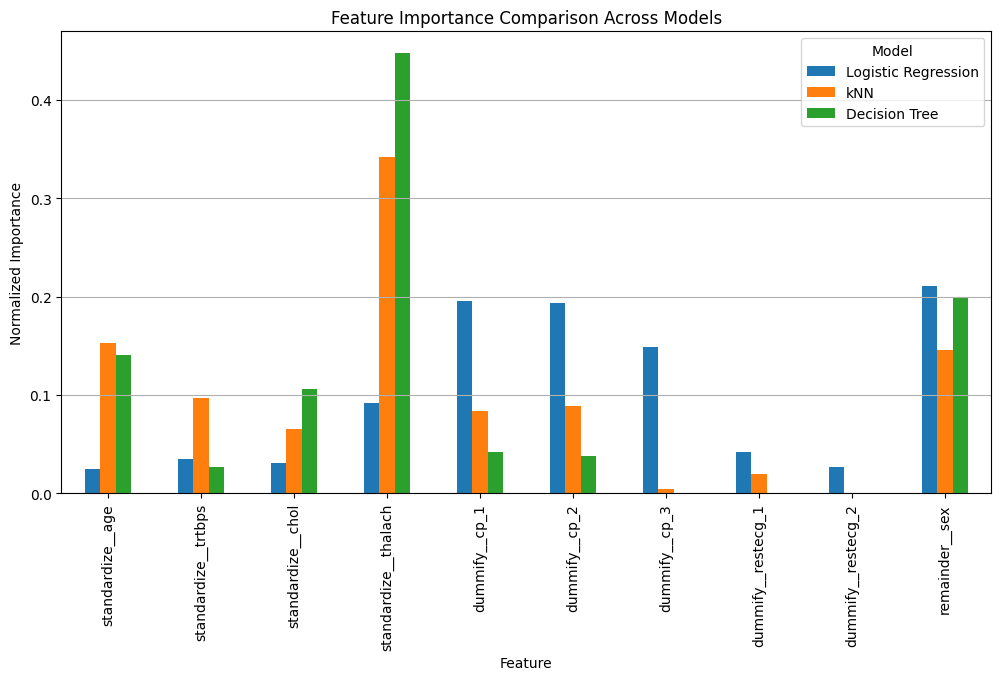

In [33]:
comparison.set_index('Feature').plot(kind='bar', figsize=(12, 6))
plt.title("Feature Importance Comparison Across Models")
plt.ylabel("Normalized Importance")
plt.xlabel("Feature")
plt.legend(title="Model")
plt.grid(axis='y')
plt.show()


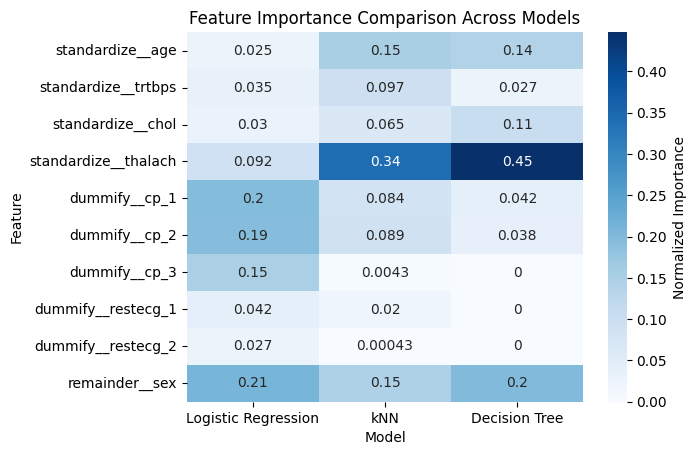

In [34]:
# heat map
import seaborn as sns

sns.heatmap(comparison.set_index('Feature'), annot=True, cmap='Blues', cbar_kws={'label': 'Normalized Importance'})
plt.title("Feature Importance Comparison Across Models")
plt.ylabel("Feature")
plt.xlabel("Model")
plt.show()

#### plot heat map
import seaborn as sns

sns.heatmap(comparison.set_index('Feature'), annot=True, cmap='Blues', cbar_kws={'label': 'Normalized Importance'})
plt.title("Feature Importance Comparison Across Models")
plt.ylabel("Feature")
plt.xlabel("Model")
plt.show()

We can see from the visualization above, thalach(maximum heart rate achieved during exercise) is the most important predictor to predicting heart attack risk

## ROC Curve

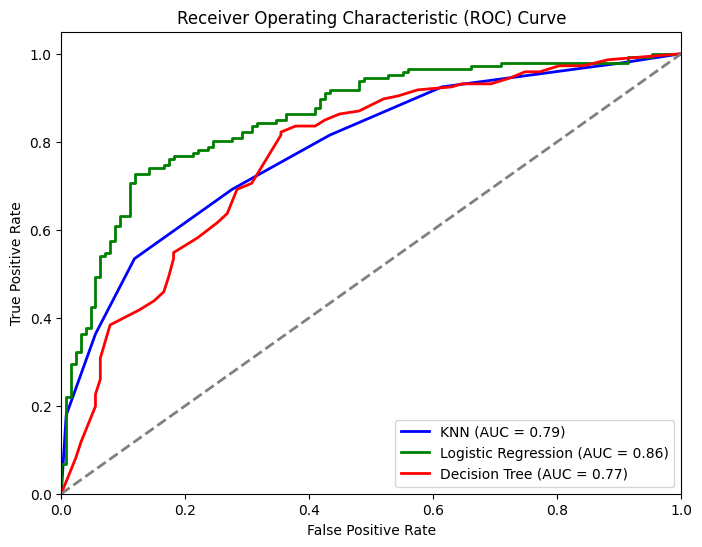

In [35]:
# Get predicted probabilities for kNN
knn_probs = cross_val_predict(best_knn, X, y, cv=5, method='predict_proba')[:, 1]
# Compute ROC curve and AUC for KNN
fpr_knn, tpr_knn, _ = roc_curve(y, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

log_reg_probs = cross_val_predict(best_logreg, X, y, cv=5, method='predict_proba')[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y, log_reg_probs)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

dt_probs = cross_val_predict(best_dt, X, y, cv=5, method='predict_proba')[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y, dt_probs)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curves for all three models
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Plot ROC for Random Classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Part Two: Metrics

In [36]:
merged_df = knn_df.merge(logreg_df, on='Metric').merge(dt_df, on='Metric')

print(merged_df)

               Metric       kNN  Logistic Regression  Decision tree
0  True Positive Rate  0.691781             0.801370       0.705479
1           Precision  0.742647             0.780000       0.725352
2  True Negative Rate  0.724409             0.740157       0.692913


## Part Three: Discussion

#### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

In this case, the hospital would face severe lawsuits if false negatives happens. Therefore, we should **use recall rate as the selection method**, prioritize getting a high true positive rate.

Based on the result calculated in Part2, Logistic Regression has the highest recall rate, indicating that it's the best model to use in this case to reduce false negatives.

Based on the cross-validated recall score of 0.8, we can expect the logistic regression model to correctly identify approximately 80% of high-risk patients when predicting future observations.

#### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Since the hospital has limited bed space, it needs to **reduce false positives** which leads to **using precision rate for model selection.**

Based on the result calculated in Part2, Logistic Regression has the highest precision rate, indicating that it's the best model to use in this case to reduce false positives.

Based on the cross-validated precision score of 0.78, we can expect the logistic regression model to correctly identify approximately 78% of high-risk patients that are indeed in high rish when predicting future observations.

#### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

Since the hospital wants to know which biological measures are associated with heart attack risk, so we focus on betas(predictor variables' coefficients) to select the best model to use

In this case, logisti regression model would be the best model because it provides interpretable coefficients that indicates the strength and direction between the predictor and outcome variable.
Models like decision tree and kNN also provides feature importance, but they are harder to explain compare to coefficients.

Based on the coefficients result calculated in the previous part in for logistic regression model, 'sex' is the biological measure that most associated with heart attack risk

#### Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Since we want to measure the accuracy of different doctors' diagnoses, we use overall accuracy as the metric for model selection

In [37]:
accuracy_df = pd.DataFrame({
    'Model': ['kNN', 'Logistic Regression', 'Decision Tree'],
    'Overall Accuracy': [round(knn_accuracy.mean(), 2), round(logreg_accuracy.mean(), 2), round(dt_accuracy.mean(), 2)]
})

print(accuracy_df)

                 Model  Overall Accuracy
0                  kNN              0.71
1  Logistic Regression              0.77
2        Decision Tree              0.70


Bason the dataframe shown above, logistic regreesion model has the best overall accuracy, so the hospital to use logistic regression model in this case.

The overall accuracy score of 0.77 indicates that this model would correctly predict 77% of cases as either at risk or not at risk. This can help the hospital evaluate the accuracy of doctors' dignoses.

## Part Four: Validation

In [38]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

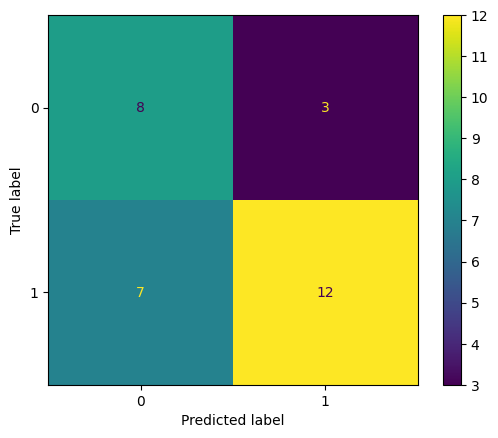

In [39]:
X_validation = ha_validation.drop('output', axis=1)
y_validation = ha_validation['output']

# knn confusion matrix
knn_pred_valid = best_knn.predict(X_validation)
#knn_pred_valid = cross_val_predict(best_knn, X_validation, y_validation, cv=5)

conf_matrix = confusion_matrix(y_validation, knn_pred_valid)
#conf_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn.classes_)
disp.plot(cmap="viridis")

In [40]:
print(classification_report(y_validation, knn_pred_valid))

              precision    recall  f1-score   support

           0       0.53      0.73      0.62        11
           1       0.80      0.63      0.71        19

    accuracy                           0.67        30
   macro avg       0.67      0.68      0.66        30
weighted avg       0.70      0.67      0.67        30



In [41]:
# True Positive Rate(Recall)
knn_recall_valid = 12/(12+7)
# Precision (Positive Predicted Value)
knn_precision_valid = 12/(12+3)
# True Negative Rate (Specificity)
knn_speci_valid = 8/(8+3)

knn_df_valid = pd.DataFrame({
    'Metric': ['True Positive Rate', 'Precision', 'True Negative Rate'],
    'kNN': [knn_recall_valid, knn_precision_valid, knn_speci_valid]
})

print(knn_df_valid)

               Metric       kNN
0  True Positive Rate  0.631579
1           Precision  0.800000
2  True Negative Rate  0.727273


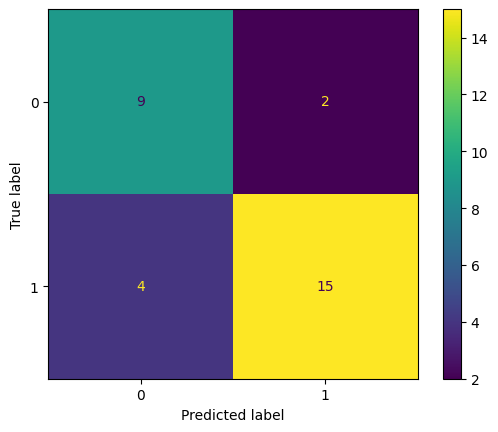

In [42]:
# logistic regression confusion matrix
logreg_pred_valid = best_logreg.predict(X_validation)
#logreg_pred_valid = cross_val_predict(best_logreg, X_validation, y_validation, cv=5)

conf_matrix = confusion_matrix(y_validation, logreg_pred_valid)
#conf_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_logreg.named_steps['logreg'].classes_)
disp.plot(cmap="viridis")

In [43]:
print(classification_report(y_validation, logreg_pred_valid))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.88      0.79      0.83        19

    accuracy                           0.80        30
   macro avg       0.79      0.80      0.79        30
weighted avg       0.81      0.80      0.80        30



In [44]:
# True Positive Rate(Recall)
logreg_recall_valid = 15/(15+4)
# Precision (Positive Predicted Value)
logreg_precision_valid = 15/(15+2)
# True Negative Rate (Specificity)
logreg_speci_valid = 9/(9+2)

logreg_df_valid = pd.DataFrame({
    'Metric': ['True Positive Rate', 'Precision', 'True Negative Rate'],
    'Logistic Regression': [logreg_recall_valid, logreg_precision_valid, logreg_speci_valid]
})

print(logreg_df_valid)

               Metric  Logistic Regression
0  True Positive Rate             0.789474
1           Precision             0.882353
2  True Negative Rate             0.818182


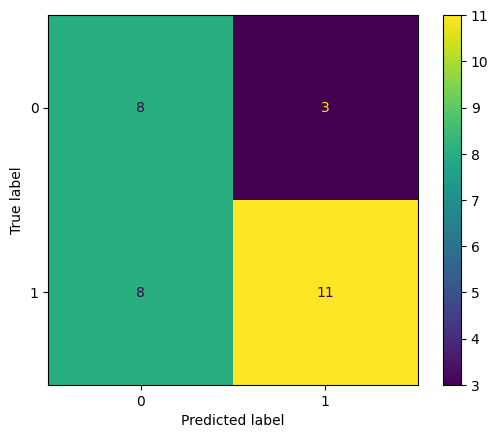

In [47]:
# confusion matrix
dt_pred_valid = best_dt.predict(X_validation)
# dt_pred_valid = cross_val_predict(best_dt, X_validation, y_validation, cv=5)

conf_matrix = confusion_matrix(y_validation, dt_pred_valid)
#conf_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_dt.named_steps['dt'].classes_)
disp.plot(cmap="viridis")

In [46]:
print(classification_report(y_validation, dt_pred_valid))

              precision    recall  f1-score   support

           0       0.50      0.73      0.59        11
           1       0.79      0.58      0.67        19

    accuracy                           0.63        30
   macro avg       0.64      0.65      0.63        30
weighted avg       0.68      0.63      0.64        30



In [48]:
# True Positive Rate(Recall)
dt_recall_valid = 11/(11+8)
# Precision (Positive Predicted Value)
dt_precision_valid = 11/(11+3)
# True Negative Rate (Specificity)
dt_speci_valid = 8/(8+3)

dt_df_valid = pd.DataFrame({
    'Metric': ['True Positive Rate', 'Precision', 'True Negative Rate'],
    'Decision Tree': [dt_recall_valid, dt_precision_valid, dt_speci_valid]
})

print(dt_df_valid)

               Metric  Decision Tree
0  True Positive Rate       0.578947
1           Precision       0.785714
2  True Negative Rate       0.727273


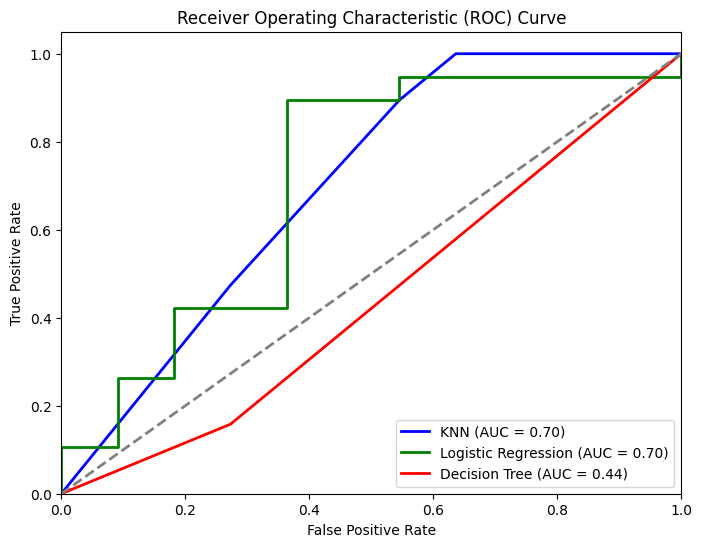

In [49]:
# Get predicted probabilities for kNN
knn_probs_valid = cross_val_predict(best_knn, X_validation, y_validation, cv=5, method='predict_proba')[:, 1]
# Compute ROC curve and AUC for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_validation, knn_probs_valid)
roc_auc_knn = auc(fpr_knn, tpr_knn)

logreg_probs_valid = cross_val_predict(best_logreg, X_validation, y_validation, cv=5, method='predict_proba')[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_validation, logreg_probs_valid)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

dt_probs_valid = cross_val_predict(best_dt, X_validation, y_validation, cv=5, method='predict_proba')[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_validation, dt_probs_valid)
roc_auc_dt = auc(fpr_dt, tpr_dt)


plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Plot ROC for Random Classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [50]:
merged_df_valid = knn_df_valid.merge(logreg_df_valid, on='Metric').merge(dt_df_valid, on='Metric')
merged_df_valid

,Metric,kNN,Logistic Regression,Decision Tree
0,True Positive Rate,0.631579,0.789474,0.578947
1,Precision,0.800000,0.882353,0.785714
2,True Negative Rate,0.727273,0.818182,0.727273


In [51]:
# scores for original data
merged_df

,Metric,kNN,Logistic Regression,Decision tree
0,True Positive Rate,0.691781,0.801370,0.705479
1,Precision,0.742647,0.780000,0.725352
2,True Negative Rate,0.724409,0.740157,0.692913


The cross-validated in part1 and part2 are reliable in general, particularly **for logistic regression, where recall and precision rate aligned closely with or exceed expectations**. This suggests that **logistic regression is the most generalizable model for this dataset**(problem).

**kNN and decision tree model** showed some deviation, especially in recall, with lower scores on the validation dataset compared to the cross-validated results. This indicates that these two models **are overfitting**, performing better in the training data but not as good in the validation data.

Overall, the cross-validated estimates provides a good indication of the models. The validation process also **confirms that logistic regression model is the strongest model out of the three**, which we observed in part3.

## Part Five: Cohen’s Kappa

In [52]:
# kNN
X = ha.drop('output', axis=1)
y = ha['output']

best_knn = Pipeline([
    ('preprocess', ct),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])

best_knn.fit(X, y)
y_pred_cv = cross_val_predict(best_knn, X, y, cv=5)

kappa = cohen_kappa_score(y, y_pred_cv)
print(f"kNN Cohen's Kappa: {kappa:.2f}")

kNN Cohen's Kappa: 0.41


In [53]:
# Logistic Regression

best_params = {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

best_logreg = Pipeline([
    ('preprocess', ct),
    ('logreg', LogisticRegression(C=best_params['logreg__C'],
                                  penalty=best_params['logreg__penalty'],
                                  solver=best_params['logreg__solver'],
                                  max_iter=1000, random_state=42))
])
best_logreg.fit(X, y)

y_pred_cv = cross_val_predict(best_logreg, X, y, cv=5)
kappa = cohen_kappa_score(y, y_pred_cv)
print(f"Logistic Regression Cohen's Kappa: {kappa:.2f}")

Logistic Regression Cohen's Kappa: 0.54


In [55]:
# Decision Tree

best_dt = Pipeline([
    ('preprocess', ct),
    ('dt', DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 14, random_state=42))
])

best_dt.fit(X, y)
y_pred_cv = cross_val_predict(best_dt, X, y, cv=5)

kappa = cohen_kappa_score(y, y_pred_cv)
print(f"Decision Tree Cohen's Kappa: {kappa:.2f}")

Decision Tree Cohen's Kappa: 0.40


In [56]:
cohen_kappa = pd.DataFrame({
    'Model': ['kNN', 'Logistic Regression', 'Decision Tree'],
    'cohen kappa score': ["0.41", "0.54", "0.40"]
})

cohen_kappa

,Model,cohen kappa score
0,kNN,0.41
1,Logistic Regression,0.54
2,Decision Tree,0.40


Cohen’s Kappa is preferred when:

- Need to account for agreement by chance.
- Evaluating models on imbalanced datasets.
- Comparing multiple models, raters, or classifiers.
- Want a metric that generalizes well to multi-class problems.

According to the cohen's kappa score, logistic regression model has the highest score suggesting that it's the best model in this case which alligns with our conclusion above when using other evaluation metrics.